# **Pneumonia Detection Challenge - Project**

### Context

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


### Data Description

In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.


### **Milestone 1**

#### **Step 1: Import the data**

In [1]:
%pip install pydicom

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import required libraries

import os
import cv2
import random
import pydicom
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from tensorflow.keras import layers, models, optimizers
from tabulate import tabulate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)



# Ignoring warnings
warnings.filterwarnings("ignore")

In [3]:
# Define paths
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'
train_images_dir = './stage_2_train_images/stage_2_train_images'

# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print(train_labels_df.head())
print("\nClass Info DataFrame (First 5 rows):")
print(class_info_df.head())

# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")

print("\nClass Info DataFrame Info:")
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")

# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print(train_labels_df.isnull().sum())
print("\nMissing values in Class Info DataFrame:")
print(class_info_df.isnull().sum())

# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print(f"Number of unique patients in Class Info: {unique_patients_class}")

Train Labels DataFrame (First 5 rows):
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

Class Info DataFrame (First 5 rows):
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Train Labels DataFrame Info:
Shape: (302

#### **Step 2: Map training and testing images to its classes**


Class Distribution:
class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


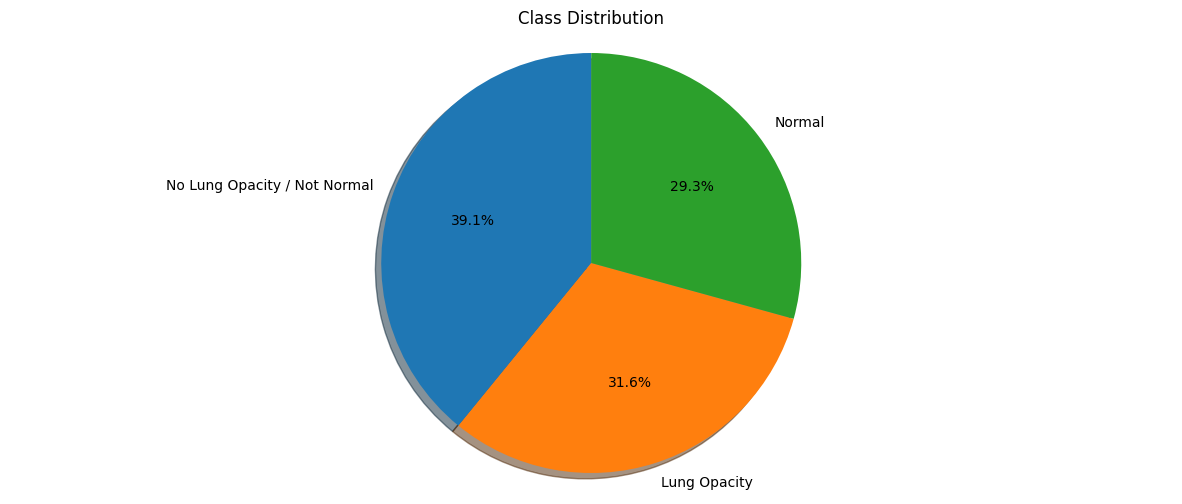

In [4]:
patient_class_df = class_info_df.copy()

# Count the number of instances for each class
class_counts = patient_class_df['class'].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Create a pie chart for class distribution
plt.figure(figsize=(15, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution')
plt.axis('equal') 
plt.show()

In [5]:
# Create a mapping of patient IDs to their respective bounding boxes
patient_boxes = {}
for index, row in train_labels_df.iterrows():
    patient_id = row['patientId']
    target = row['Target']
    
    if target == 1:  # Only consider rows with Target=1 (has bounding box)
        if patient_id not in patient_boxes:
            patient_boxes[patient_id] = []
        
        # Add bounding box coordinates
        patient_boxes[patient_id].append({
            'x': row['x'],
            'y': row['y'],
            'width': row['width'],
            'height': row['height']
        })

# Create a mapping of patient IDs to their classes
patient_class_map = dict(zip(patient_class_df['patientId'], patient_class_df['class']))

# Create a combined dataframe for easier analysis
combined_df = train_labels_df.merge(class_info_df, on='patientId', how='left')

# Display first few rows of combined DataFrame
print("\nCombined DataFrame (First 5 rows):")
print(tabulate(combined_df.head().values, headers=combined_df.columns, tablefmt='github'))

# Count the number of patients with bounding boxes
patients_with_boxes = len(patient_boxes)
print(f"\nNumber of patients with bounding boxes: {patients_with_boxes}")

# Bounding box and unique patient count per class
boxed_df = combined_df[combined_df['Target'] == 1]
class_box_counts = boxed_df.groupby('class').size()
class_patient_counts = boxed_df.groupby('class')['patientId'].nunique()

# Combine into table
class_stats = pd.DataFrame({
    'BoundingBox Count': class_box_counts,
    'Unique Patients with Box': class_patient_counts
}).reset_index()

# Display summary table
print("\nBounding box and patient counts per class:")
print(tabulate(class_stats, headers='keys', tablefmt='github', showindex=False))


Combined DataFrame (First 5 rows):
| patientId                            |   x |   y |   width |   height |   Target | class                        |
|--------------------------------------|-----|-----|---------|----------|----------|------------------------------|
| 0004cfab-14fd-4e49-80ba-63a80b6bddd6 | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 00313ee0-9eaa-42f4-b0ab-c148ed3241cd | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 00322d4d-1c29-4943-afc9-b6754be640eb | nan | nan |     nan |      nan |        0 | No Lung Opacity / Not Normal |
| 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 | nan | nan |     nan |      nan |        0 | Normal                       |
| 00436515-870c-4b36-a041-de91049b9ab4 | 264 | 152 |     213 |      379 |        1 | Lung Opacity                 |

Number of patients with bounding boxes: 6012

Bounding box and patient counts per class:
| class        |   BoundingBox Count |   Unique Patients with 

In [6]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, img_size=(256, 256)):
    """
    Load and preprocess a DICOM image for a given patient ID
    
    Parameters:
    - patient_id: ID of the patient
    - img_size: Tuple of (height, width) for resizing
    
    Returns:
    - Preprocessed image as numpy array
    """
    # Construct file path
    file_path = os.path.join(train_images_dir, f"{patient_id}.dcm")
    
    # Read DICOM file
    dicom = pydicom.dcmread(file_path)
    
    # Convert to numpy array
    image = dicom.pixel_array
    
    # Normalize pixel values to be between 0 and 1
    image = image / np.max(image)
    
    # Convert to grayscale if necessary
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Resize image
    image = cv2.resize(image, img_size[::-1])  # Note: cv2.resize expects (width, height)
    
    # Expand dimensions for CNN input (add channel dimension)
    image = np.expand_dims(image, axis=-1)
    
    return image

In [7]:
# Sample a few images from each class for visualization
def sample_patients_from_class(class_name, n=4):
    """Sample n patient IDs from a given class"""
    return random.sample(list(patient_class_df[patient_class_df['class'] == class_name]['patientId']), n)

# Sample patient IDs from each class
normal_patients = sample_patients_from_class('Normal',3)
opacity_patients = sample_patients_from_class('Lung Opacity',3)
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal',3)

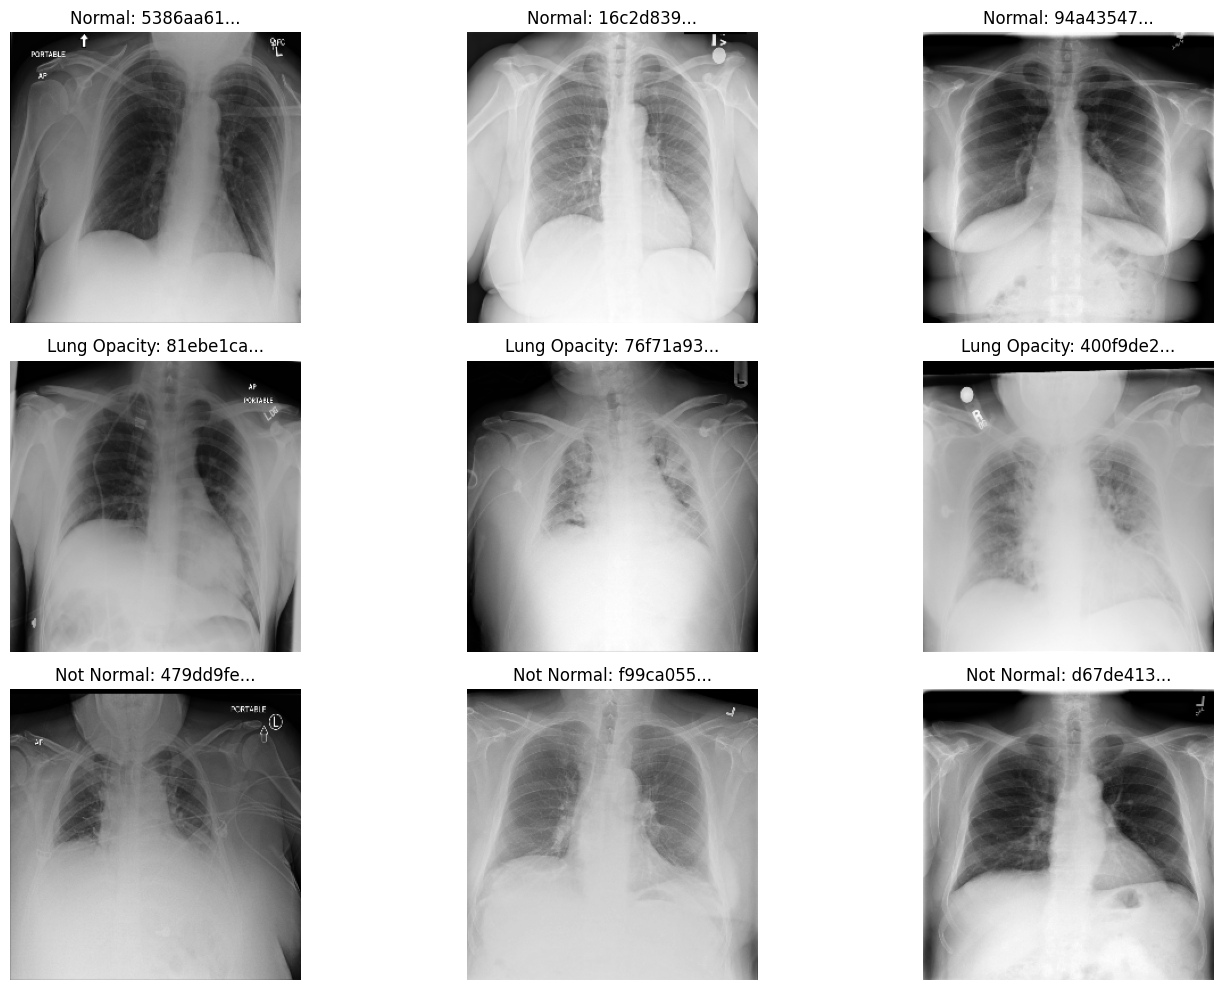

In [8]:
# Plot sample images from each class
plt.figure(figsize=(15, 10))

# Plot Normal images
for i, patient_id in enumerate(normal_patients):
    plt.subplot(3, 3, i+1)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Normal: {patient_id[:8]}...")
    plt.axis('off')

# Plot Lung Opacity images
for i, patient_id in enumerate(opacity_patients):
    plt.subplot(3, 3, i+4)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Lung Opacity: {patient_id[:8]}...")
    plt.axis('off')

# Plot Not Normal No Lung Opacity images
for i, patient_id in enumerate(not_normal_patients):
    plt.subplot(3, 3, i+7)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Not Normal: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Function to load DICOM image with original size
def load_original_dicom(patient_id):
    """Load DICOM image without resizing"""
    file_path = os.path.join(train_images_dir, f"{patient_id}.dcm")
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    image = image / np.max(image)
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [10]:
# Function to draw bounding boxes on image
def draw_boxes(image, boxes):
    """Draw bounding boxes on the image"""
    
    # Ensure image is in uint8 format (0-255)
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)
    
    # Convert grayscale image to RGB for colored boxes
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for box in boxes:
        x, y = int(box['x']), int(box['y'])
        w, h = int(box['width']), int(box['height'])
        image_color = cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_color

In [11]:
# Sample a few patients with Lung Opacity (which have bounding boxes)
opacity_patients = sample_patients_from_class('Lung Opacity')
opacity_with_boxes = [pid for pid in opacity_patients if pid in patient_boxes]

if not opacity_with_boxes:
    opacity_with_boxes = list(set(patient_boxes.keys()) & 
                             set(patient_class_df[patient_class_df['class'] == 'Lung Opacity']['patientId']))[:4]


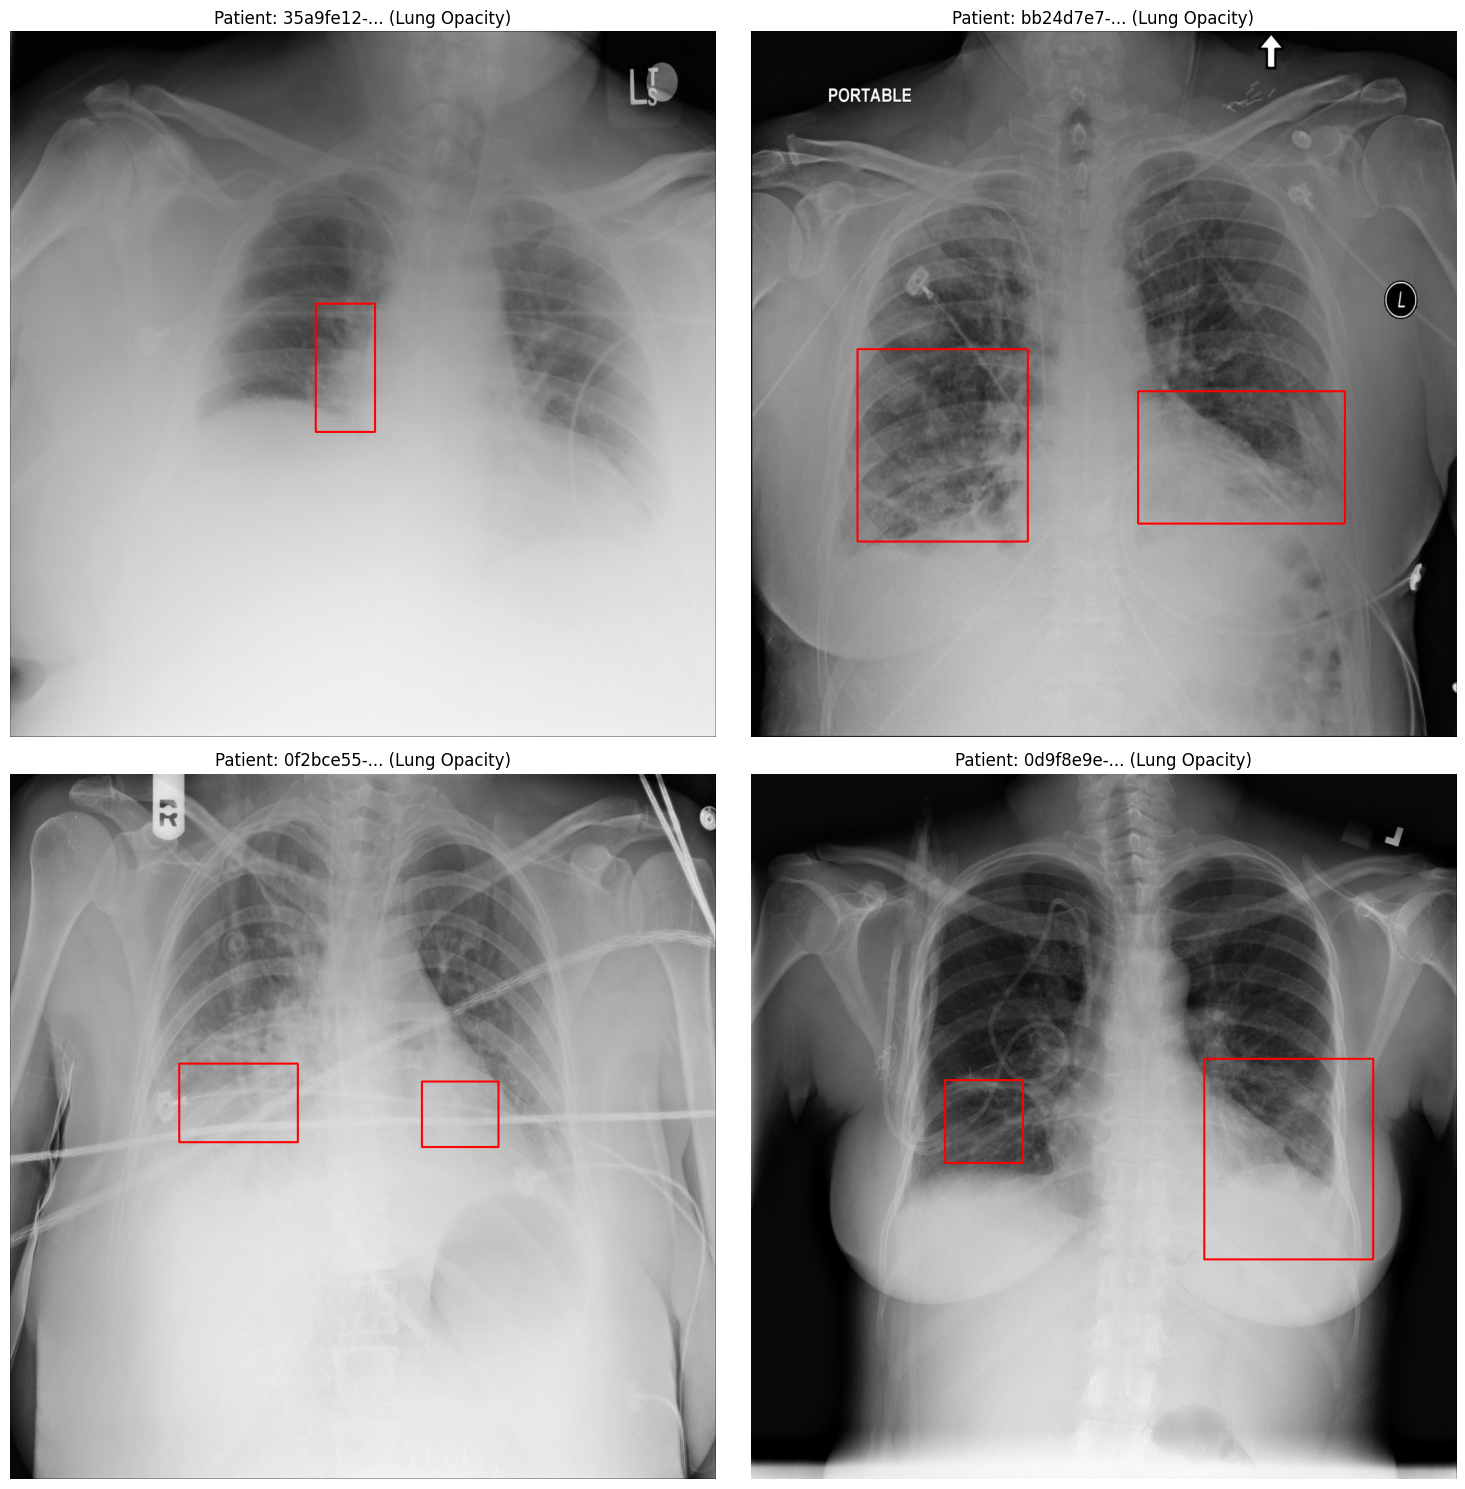

In [12]:
# Plot images with bounding boxes
plt.figure(figsize=(15, 15))

for i, patient_id in enumerate(opacity_with_boxes[:4]):
    try:
        plt.subplot(2, 2, i + 1)
        img = load_original_dicom(patient_id)

        if img is None:
            print(f"[Warning] Image for patient {patient_id} is None.")
            continue

        if patient_id in patient_boxes:
            img_with_boxes = draw_boxes(img, patient_boxes[patient_id])
            plt.imshow(img_with_boxes, cmap='gray')
        else:
            plt.imshow(img, cmap='gray')

        plt.title(f"Patient: {patient_id[:9]}... (Lung Opacity)")
        plt.axis('off')

    except Exception as e:
        print(f"[Error] Failed on patient {patient_id}: {e}")

plt.tight_layout()
plt.show()
